# Compare Fractional Cover To MODIS FPAR product <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[ls_usgs_fc_scene](https://explorer.digitalearth.africa/ls_usgs_fc_scene), 
[ls_usgs_wofs_scene](https://explorer.digitalearth.africa/ls_usgs_wofs_scene),
[s2_l2a](https://explorer.digitalearth.africa/s2_l2a)
* **Prerequisites:** For more details and better understanding of the input datasets and method used, see the notebooks covering [Sentinel-2](../Datasets/Sentinel_2.ipynb), [Applying WOfS bitmasking](../Frequently_used_code/Applying_WOfS_bitmasking.ipynb) and [Geomedian](../Frequently_used_code/Generating_geomedian_composites.ipynb).


### Background

The Fractional Cover (FC) product provides estimates of the proportions of green vegetation, non-green vegetation (including deciduous trees during autumn, dry grass, etc.), and bare soils for every Landsat or Sentinel-2 pixel.

This product supports a range of environmental and agricultural applications, including soil erosion monitoring, land surface process modelling, land management and vegetation studies. The information can be used by policy agencies, natural and agricultural land resource managers, and scientists to monitor land conditions over large areas over long time periods.

The algorithm is developed by the Joint Remote Sensing Research Program (JRSRP) and is described in Scarth et al. (2010). Field data collected across Australia have been used to calibrate and validate the unmixing model.

More information on the product can be found [here](http://data.auscover.org.au/xwiki/bin/view/Product+pages/Landsat+Seasonal+Fractional+Cover).

**Reference**

Scarth, P, Roder, A and Schmidt, M 2010, 'Tracking grazing pressure and climate interaction - the role of Landsat fractional cover in time series analysis', Proceedings of the 15th Australasian Remote Sensing & Photogrammetry Conference (ARSPC), 13-17 September, Alice Springs, Australia. Alice Springs, NT.



## Description

This notebook will cover following topics:

1. 

***

## Getting started

To use this notebook, run the cells in this section, under "Load packages", "Connect to the datacube" and "Analysis parameters".

The two sections below, "Loading, masking and visualizing pre-generated FC data" and "Calculating FC from Sentinel-2 surface reflectance" can be run independently.

### Load packages
Import Python packages that are used for the analysis.

In [33]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import xarray as xr
import glob
import numpy as np
from skimage.morphology import disk, binary_erosion, binary_dilation
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr
from matplotlib.colors import LogNorm
from matplotlib import pyplot as plt

import datacube
from datacube.utils import masking

import sys
sys.path.append('../Scripts')
from deafrica_plotting import rgb

In [34]:
def plot_arr1_arr2_100(arr1, arr2, name1, name2, ax, title='', f=sys.stdout):
    xedges=list(np.arange(0, 100, 2))
    yedges = list(np.arange(0, 100, 2))
    valid = (~np.isnan(arr1)) & (~np.isnan(arr2))
    arr1, arr2 = arr1[valid], arr2[valid]

    regr = linear_model.LinearRegression(fit_intercept=True)
    regr.fit(arr1[:,np.newaxis], arr2[:,np.newaxis])
    ## The coefficients
    print('Band:{0}, slope={1}, intercept={2}, r2={3}'.format('PV', regr.coef_[0][0], regr.intercept_[0], 
                                                regr.score(arr1[:,np.newaxis], arr2[:,np.newaxis])), file=f)

    rmse = mean_squared_error(arr1, arr2, squared=False)
    print('RMSE:',rmse, file=f)
    rmse_fitted = mean_squared_error(regr.predict(arr1[:,np.newaxis]), arr2[:,np.newaxis], squared=False)
    print('RMSE_fitted:',rmse_fitted, file=f)
    pr = pearsonr(arr1, arr2)
    print('Pearsonr:', pr[0], pr[1], file=f)
 
    X, Y = np.meshgrid(xedges[:-1], yedges[:-1])
    cmname='YlGnBu'
    hist, xe, ye= np.histogram2d(arr2, arr1, bins=(yedges, xedges))

    ax.pcolor(X, Y, hist, cmap=cmname, norm=LogNorm(1, vmax=hist.max()))
    #plt.colorbar();
    #plt.contour(X, Y, np.log10(hist), cmap=cmname, levels=5)
    ax.plot(xedges, regr.predict(np.array(xedges)[:,np.newaxis]), ':');

    ax.set_xlim((0,100));
    ax.set_ylim((0,100));
    ax.set_xlabel(name1);
    ax.set_ylabel(name2);
    ax.set_title(title);

    ax.text(5, 94, f'slope={regr.coef_[0][0]:.2f} intercept={regr.intercept_[0]:.2f}');
    ax.text(5, 88, f'pearsonr={pr[0]:.02f}')
    ax.text(5, 82, f'rmse={rmse:.2f}');
    ax.text(5, 76, f'rmse_fitted={rmse_fitted:.2f}');

In [35]:
from deafrica_dask import create_local_dask_cluster
create_local_dask_cluster(n_workers=10,threads_per_worker=1)

Client Scheduler: tcp://127.0.0.1:37193 Dashboard: /user/fangfy/proxy/8787/status,Cluster Workers: 10 Cores: 10 Memory: 104.37 GB


## Load MODIS data

In [45]:
modis_path = '../../greenfraction/MODIS_Senegal'

In [46]:
fpars = glob.glob(f'{modis_path}/*A2017*_Fpar_500m.tif')
fpars.sort()

In [47]:
def load_modis_fpar(fpar):
    bands = ["Fpar_500m", "FparLai_QC", "FparExtra_QC", "FparStdDev_500m"]
    # lai bands "Lai_500m", "LaiStdDev_500m"
    if not bands[0] in fpar:
        print("Fpar_500m filename is required.")
        return
    year, day = fpar.split('/')[-1].split('.')[1][1:5], fpar.split('/')[-1].split('.')[1][5:]
    time = np.datetime64(year) + np.timedelta64(int(day)-1, 'D')
    dataset = xr.open_rasterio(fpar).to_dataset(dim='band').rename({1:bands[0]})
    attrs = dataset.attrs
    for b in bands[1:]:
        dataset = xr.merge([dataset, xr.open_rasterio(fpar.replace(bands[0], b)).to_dataset(dim='band').rename({1:b})])
    dataset.attrs=attrs
    return dataset.expand_dims({'time':[time]})

### Connect to the datacube

Connect to the datacube so we can access DE Africa data.

In [48]:
dc = datacube.Datacube(app='greencover')

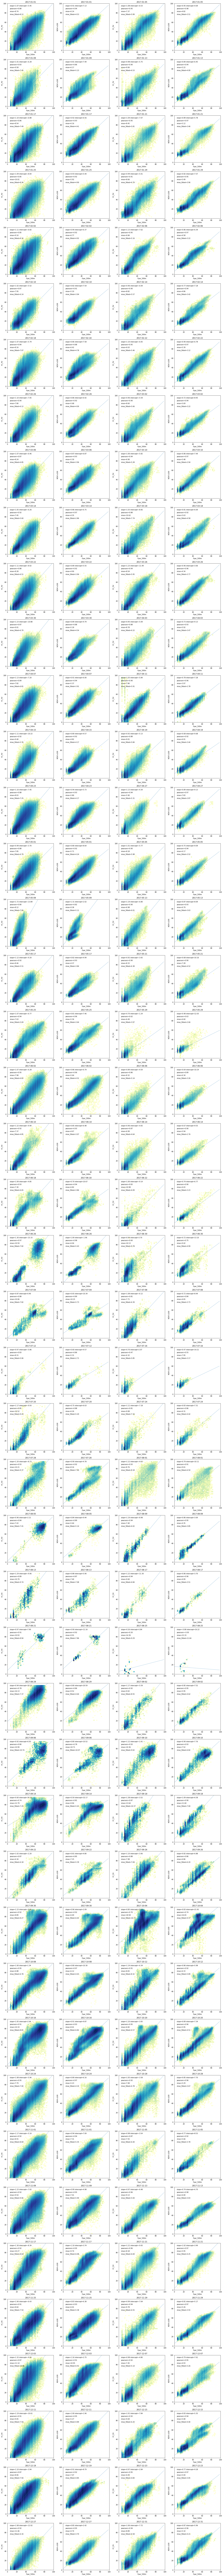

In [49]:
def load_compare_pv(fpar_data, ax_pv, ax_ndvi, f_pv, f_ndvi):
    # mask fpar
    mask = (fpar_data.Fpar_500m<200) & (fpar_data.FparLai_QC & int('11111101', 2) ==0) & (fpar_data.FparExtra_QC & int('01110111', 2) ==0)
    mask = binary_erosion(mask.squeeze().data, disk(2))
    
    time = str(fpar_data.time.values[0]-np.timedelta64(2,'D')), str(fpar_data.time.values[0]+np.timedelta64(2,'D'))
    
    # load FC
    ls_fc = dc.load(product='ls_usgs_fc_scene',
                time=time,
                like=fpar_data,
                resampling='average', 
                group_by='solar_day',
                measurements=['PV', 'UE'],
               )
    fc_mask = (ls_fc.PV>0) & (ls_fc.UE<20)
    ls_pv = ls_fc.PV.where(fc_mask).max(dim='time')
    
    # masking with wofl
    wofl = dc.load(product='ls_usgs_wofs_scene', time=time,
               geopolygon=ls_fc.geobox.extent, group_by='solar_day', dask_chunks={'x':3200, 'y':3200},
               resolution=(-30,30), output_crs=ls_fc.crs).sel(time=ls_fc.time)
    clear_and_dry = masking.make_mask(wofl, dry=True).water
    clear_and_dry = clear_and_dry.coarsen(x=int(clear_and_dry.shape[-1]/ls_fc.PV.shape[-1])+1,
                                           y=int(clear_and_dry.shape[-2]/ls_fc.PV.shape[-2])+1,
                                           boundary='pad').min().astype(int)
    clear_and_dry = clear_and_dry.interp_like(ls_fc.isel(time=0), method='nearest').max(dim='time').compute()
    
    fpar_valid = fpar_data.Fpar_500m.where(mask).where(ls_pv.values>0).where(clear_and_dry.values).squeeze()
    pv_valid = ls_pv.where(mask).where(clear_and_dry.values)
    
    ndvi_data = []
    for product in ['ls7_usgs_sr_scene', 'ls8_usgs_sr_scene']:
        ls_data = dc.load(product=product, 
                time=time,
                like=fpar_data,
                resampling='average', 
                group_by='solar_day',
                measurements=['red', 'nir'],
               )
        if 'red' in ls_data: ndvi_data.append(ls_data.where(ls_data>0))
    ls_data = xr.concat(ndvi_data, dim='time')
    ndvi = ((ls_data.nir - ls_data.red)/(ls_data.nir + ls_data.red)).max(dim='time')
    ndvi_valid = ndvi.where(mask).where(clear_and_dry.values)
    
    arr1 = fpar_valid.values.flatten()
    arr2 = pv_valid.values.flatten()
    plot_arr1_arr2_100(arr1, arr2, 'Fpar_500m', 'FC_PV', ax_pv, f=f_pv,
                       title=str(fpar_data.time.values[0])[:10])
    
    arr1 = fpar_valid.values.flatten()
    arr2 = ndvi_valid.values.flatten()*100
    plot_arr1_arr2_100(arr1, arr2, 'Fpar_500m', 'NDVI x100', ax_ndvi, f=f_ndvi,
                       title=str(fpar_data.time.values[0])[:10])

   
    
ncol = 4
nrow = np.ceil(len(fpars)/ncol).astype(int)*2
fig, axes = plt.subplots(nrow, ncol, figsize=(20, 20*nrow/ncol))
axes = axes.flatten()

f_pv = open(f'{modis_path}/PV_vs_Fpar_500m_correlation','w')
f_ndvi = open(f'{modis_path}/NDVI_vs_Fpar_500m_correlation','w')

for idx, fpar in enumerate(fpars):
    fpar_data = load_modis_fpar(fpar)
    load_compare_pv(fpar_data, axes[idx*2], axes[idx*2+1], f_pv, f_ndvi)
    
f_pv.close()
f_ndvi.close()
fig.tight_layout()
fig.savefig(f'{modis_path}/PV_NDVI_vs_Fpar_500m.png')

In [50]:
with open(f'{modis_path}/PV_vs_Fpar_500m_correlation') as f:
    ls = f.readlines()
    
slopes =[]
intercepts = []
pearsonrs = []
rmses = []
rmses_fitted = []
for l in ls:
    if 'slope' in l: slopes.append(float(l.split('slope=')[1].split(',')[0]))
    if 'intercept' in l: intercepts.append(float(l.split('intercept=')[1].split(',')[0]))
    if 'Pearsonr' in l: pearsonrs.append(float(l.split('Pearsonr:')[1].strip().split()[0]))
    if 'RMSE:' in l: rmses.append(float(l.split('RMSE:')[1].strip()))
    if 'RMSE_fitted:' in l: rmses_fitted.append(float(l.split('RMSE_fitted:')[1].strip()))


In [51]:
with open(f'{modis_path}/NDVI_vs_Fpar_500m_correlation') as f:
    ls = f.readlines()
    
ndvi_slopes =[]
ndvi_intercepts = []
ndvi_pearsonrs = []
ndvi_rmses = []
ndvi_rmses_fitted = []
for l in ls:
    if 'slope' in l: ndvi_slopes.append(float(l.split('slope=')[1].split(',')[0]))
    if 'intercept' in l: ndvi_intercepts.append(float(l.split('intercept=')[1].split(',')[0]))
    if 'Pearsonr' in l: ndvi_pearsonrs.append(float(l.split('Pearsonr:')[1].strip().split()[0]))
    if 'RMSE:' in l: ndvi_rmses.append(float(l.split('RMSE:')[1].strip()))
    if 'RMSE_fitted:' in l: ndvi_rmses_fitted.append(float(l.split('RMSE_fitted:')[1].strip()))


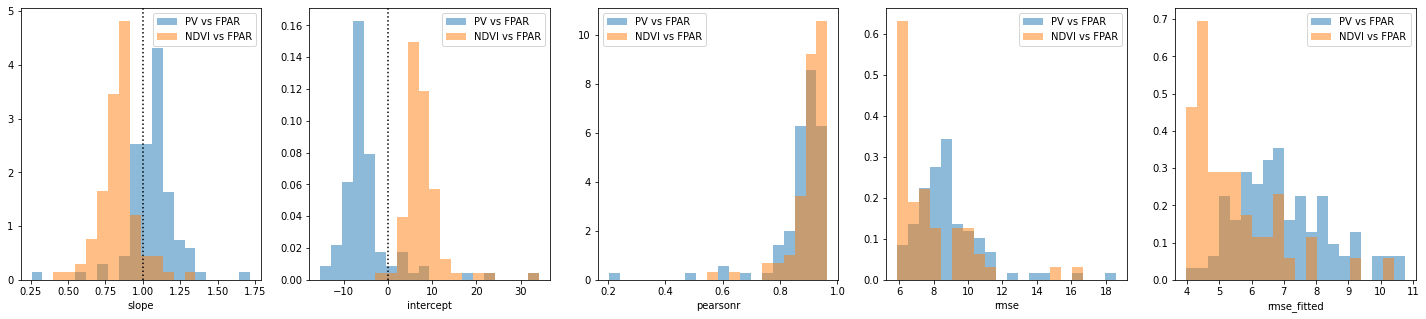

In [52]:
f, ax=plt.subplots(1, 5, figsize=(25,5))

h, b, t=ax[0].hist(slopes, bins=20, density=True, alpha=0.5, label='PV vs FPAR');
ax[0].hist(ndvi_slopes, bins=b, density=True, alpha=0.5, label='NDVI vs FPAR');
ax[0].vlines(1, *(ax[0].set_ylim()), linestyle=':')
ax[0].set_xlabel('slope');
ax[0].legend();

h, b, t=ax[1].hist(intercepts, bins=20, density=True, alpha=0.5, label='PV vs FPAR');
ax[1].hist(ndvi_intercepts, bins=b, density=True, alpha=0.5, label='NDVI vs FPAR');
ax[1].vlines(0, *(ax[1].set_ylim()), linestyle=':')
ax[1].set_xlabel('intercept');
ax[1].legend();

h, b, t=ax[2].hist(pearsonrs, bins=20, density=True, alpha=0.5, label='PV vs FPAR');
ax[2].hist(ndvi_pearsonrs, bins=b, density=True, alpha=0.5, label='NDVI vs FPAR');
ax[2].set_xlabel('pearsonr');
ax[2].legend();

h, b, t = ax[3].hist(rmses, bins=20, density=True, alpha=0.5, label='PV vs FPAR');
ax[3].hist(ndvi_rmses, bins=b, density=True, alpha=0.5, label='NDVI vs FPAR');
ax[3].set_xlabel('rmse');
ax[3].legend();

h, b, t = ax[4].hist(rmses_fitted, bins=20, density=True, alpha=0.5, label='PV vs FPAR');
ax[4].hist(ndvi_rmses_fitted, bins=b, density=True, alpha=0.5, label='NDVI vs FPAR');
ax[4].set_xlabel('rmse_fitted');
ax[4].legend();

f.savefig(f'{modis_path}/PV_NDVI_vs_Fpar_500m_summary.png')


## Step by Step comparison


### Load Fpar from one date

In [ ]:
fpar_data = load_modis_fpar(fpars[5])

In [ ]:
# https://lpdaac.usgs.gov/documents/624/MOD15_User_Guide_V6.pdf
# FparLai_QC: ignore sensor name, SCF_QC in top quality level (alternatively 11011101 for top 2 quality levels )
# FparExtra_QC: ignore biome and aerosol
mask = (fpar_data.Fpar_500m<200) & (fpar_data.FparLai_QC & int('11111101', 2) ==0) & (fpar_data.FparExtra_QC & int('01110111', 2) ==0)

In [ ]:
mask = binary_erosion(mask.squeeze().data, disk(2))

In [ ]:
#fpar_data.squeeze().to_array(dim='band').plot(col='band');

In [ ]:
#fpar_data.Fpar_500m.where(mask).squeeze().plot.imshow(); 

In [ ]:
#fpar_data.Fpar_500m.plot.hist(bins=np.arange(0,100,5));

In [ ]:
fpar_data.FparStdDev_500m.plot.hist(bins=np.arange(0,20,1));

### Load LS FC

In [ ]:
# load all available fc data
ls_fc = dc.load(product='ls_usgs_fc_scene', 
                time=(str(fpar_data.time.values[0]-np.timedelta64(2,'D')), str(fpar_data.time.values[0]+np.timedelta64(2,'D'))),
                like=fpar_data, #.isel(x=slice(1000, 2000),y=slice(1000,2000)),
                resampling='average', group_by='solar_day',
                measurements=['PV', 'UE'],
               )

In [ ]:
#ls_fc.UE.where(ls_fc.UE>0).plot.imshow(col='time');

In [ ]:
fc_mask = (ls_fc.PV>0) & (ls_fc.UE<20)
ls_pv = ls_fc.PV.where(fc_mask).max(dim='time')
#ls_pv.plot.imshow();

In [ ]:
#good_slice = fc_mask.mean(['x','y'])>0.01
#ls_fc = ls_fc.isel(time=good_slice)
#fc_mask = fc_mask.isel(time=good_slice)

### Mask with cloud, cloud shadow and water

In [ ]:
## mask FC with wofl

wofl = dc.load(product='ls_usgs_wofs_scene', time=(str(fpar_data.time.values[0]-np.timedelta64(2,'D')), str(fpar_data.time.values[0]+np.timedelta64(2,'D'))),
               geopolygon=ls_fc.geobox.extent, group_by='solar_day', dask_chunks={'x':3200, 'y':3200},
               resolution=(-30,30), output_crs=ls_fc.crs).sel(time=ls_fc.time)

In [ ]:
clear_and_dry = masking.make_mask(wofl, dry=True).water

In [ ]:
clear_and_dry = clear_and_dry.coarsen(x=int(clear_and_dry.shape[-1]/ls_fc.PV.shape[-1])+1,
                                           y=int(clear_and_dry.shape[-2]/ls_fc.PV.shape[-2])+1,
                                           boundary='pad').min().astype(int)

In [ ]:
clear_and_dry = clear_and_dry.interp_like(ls_fc.isel(time=0), method='nearest').max(dim='time')

In [ ]:
%%time
clear_and_dry = clear_and_dry.compute()

### NDVI

In [ ]:
ndvi_data = []
for product in ['ls7_usgs_sr_scene', 'ls8_usgs_sr_scene']:
    ls_data = dc.load(product=product, 
                time=(str(fpar_data.time.values[0]-np.timedelta64(2,'D')), str(fpar_data.time.values[0]+np.timedelta64(2,'D'))),
                like=fpar_data,
                resampling='average', 
                group_by='solar_day',
                measurements=['red', 'nir'],
               )
    ndvi_data.append(ls_data.where(ls_data>0))
ls_data = xr.concat(ndvi_data, dim='time')
ndvi = ((ls_data.nir - ls_data.red)/(ls_data.nir + ls_data.red)).max(dim='time')
ndvi_valid = ndvi.where(mask).where(clear_and_dry.values)

### Compare matched valid data

In [ ]:
fpar_valid = fpar_data.Fpar_500m.where(mask).where(ls_pv.values>0).where(clear_and_dry.values).squeeze()
pv_valid = ls_pv.where(mask).where(clear_and_dry.values)

In [ ]:
ncol = 4
nrow = 1#np.ceil(len(fpars)/ncol).astype(int)
fig, axes = plt.subplots(nrow, ncol, figsize=(20, 20*nrow/ncol))
axes = axes.flatten()
ax = axes[0]

arr1 = fpar_valid.values.flatten()
arr2 = pv_valid.values.flatten()

plot_arr1_arr2_100(arr1, arr2, 'Fpar_500m', 'FC_PV', ax, title=str(fpar_data.time.values[0])[:10])  

In [ ]:
ncol = 4
nrow = 1#np.ceil(len(fpars)/ncol).astype(int)
fig, axes = plt.subplots(nrow, ncol, figsize=(20, 20*nrow/ncol))
axes = axes.flatten()
ax = axes[0]

arr1 = fpar_valid.values.flatten()
arr2 = ndvi_valid.values.flatten()*100

plot_arr1_arr2_100(arr1, arr2, 'Fpar_500m', 'NDVI x100', ax, title=str(fpar_data.time.values[0])[:10])  


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** August 2020

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](https://) (placeholder as this does not exist yet)